# Find pools in City of Redlands

In [1]:
import os
from arcgis.gis import GIS
from arcgis.geocoding import geocode

gis = GIS('https://deldev.maps.arcgis.com', 'demos_deldev', os.environ.get('DEMOSPWD'))

# Inputs

In [2]:
extent = geocode('City of Redlands, CA', out_sr=3857)[0]['extent']
extent

{'xmin': -13052832.571464855,
 'ymin': 4026436.3359408537,
 'xmax': -13036579.925809037,
 'ymax': 4046053.3775858423}

<Item title:"Redlands Zoning" type:Feature Layer Collection owner:data.locadv>
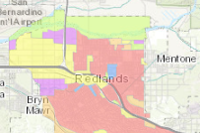

In [3]:
zoning_lyr = gis.content.get('d83b7a006f444212ac81a16399a37ac6') # Redlands Zoning 
zoning_lyr

<Item title:"USA NAIP Imagery: Color Infrared" type:Imagery Layer owner:esri>
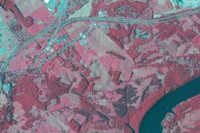

In [5]:
naip = gis.content.get('e4da3b6720f545aeaaf3fe8141da1e21') # USA NAIP Imagery: Color Infrared
naip

# Deploy trained model

### Load model

In [6]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np

from util import load_model, norm, denorm, export_img, get_tile_images, get_img, \
        get_cropped_tiles, predict_, detect_objects, suppress_close_pools, overlap, predict_classf
from model import ConvnetBuilder, SSD_MultiHead, resnet34, k

torch.backends.cudnn.benchmark=True

f_model = resnet34
pretrained = '9.h5'

In [7]:
head_reg = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg)
model = models.model
model = load_model(model, pretrained)
model.eval()

path = r'inferencing/'

In [ ]:
!mkdir $path

In [6]:
import os
import math
import pandas as pd

from arcgis.raster.functions import apply
from arcgis.features import SpatialDataFrame
from arcgis.mapping import MapImageLayer
from arcgis.geometry import Envelope, project
from IPython.display import display

ext = Envelope(extent)
city_ext = project([ext], 3857, 3857)[0]

In [7]:
naiplayer = naip.layers[0]
naipfalse = apply(naiplayer, 'FalseColorComposite')

In [8]:
df = SpatialDataFrame.from_layer(zoning_lyr.layers[0])
residential_areas = list(df[df.Zoning=='Residential']['SHAPE'].extent)

areas = [Envelope({"xmin": x[0], "ymin": x[1], "xmax": x[2], "ymax": x[3], "spatialReference": 3857}) for x in residential_areas]

In [9]:
sz = 224
pixx, pixy = 90, 90
N = 16
w = h = N*pixx - pixx/2

nX = math.ceil((city_ext['xmax'] - city_ext['xmin'])/w)
nY = math.ceil((city_ext['ymax'] - city_ext['ymin'])/h)

years      = [2014, 2016]
objects    = []
inferenced = []
done_imgs  = {}

borders = [ (45,   45,   45,   45),   # xmin, ymin, xmax, ymax - map space
          (22.5, 22.5, 67.5, 67.5),   # bottom left corner
          (22.5, 67.5, 67.5, 22.5),   # top left corner
          (67.5, 22.5, 22.5, 67.5),   # bottom right corner
          (67.5, 67.5, 22.5, 22.5) ]  # top right corner

crops   = [ (112, 112, 112, 112),  # left, top, right, bottom -> xmin, ymax, xmax, ymin
            ( 56, 168, 168,  56),  # bottom left corner
            ( 56,  56, 168, 168),  # top left corner
            (168, 168,  56,  56),  # bottom right corner
            (168,  56,  56, 168) ] # top right corner

### Detect swimming pools

In [13]:
for year in years:
    for i in range(nX):
        for j in range(nY):
            filename = f'redlands_large_{i}_{j}_({year}).jpg'

            xmin = city_ext['xmin'] + (j)*w
            ymin = city_ext['ymax'] - (i+1)*h
            xmax = xmin + N*pixx
            ymax = ymin + N*pixy

            ext = {'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax, 'spatialReference':3857}
            thisarea = Envelope(ext)

            for area in areas:
                if (overlap(area, ext)):
                    print(filename, 'Detecting...')

                    imgpath = path + filename

                    if not os.path.isfile(imgpath):
                        print(filename, 'Downloading...')
                        imgpath = naipfalse.export_image(ext, image_sr={'wkid': 3857}, 
                                         bbox_sr=3857, size=[224*8, 224*8], f='image', 
                                         export_format='jpg', adjust_aspect_ratio=False,
                                         mosaic_rule={"mosaicMethod": "esriMosaicAttribute", 
                                                "where": f'Year = {year}', 
                                                "sortField":"Year", 
                                                "sortValue":"3000", 
                                                "ascending":True, 
                                                "mosaicOperation":"MT_FIRST"},
                              save_folder=path,
                              save_file=filename)
                    
                    if filename not in inferenced:                        
                        img = np.array(Image.open(imgpath))

                        tiles = get_tile_images(img)
                        pools = detect_objects(model, tiles, ext, cycle=0)
                        print(filename, 'Found ' + str(len(pools)) + ' pools (pass #0)')
                        objects.extend(pools)

                        for iii, crop in enumerate(crops):
                            paddedtiles = get_cropped_tiles(img, crop)
                            pools = detect_objects(model, paddedtiles, ext, crop=borders[iii], cycle=iii+1)
                            print(filename, 'Found ' + str(len(pools)) + f' pools (pass #{iii+1})')
                            objects.extend(pools)

                        inferenced.append(filename)

redlands_large_1_4_(2014).jpg Detecting...
redlands_large_1_4_(2014).jpg Found 2 pools (pass #0)
redlands_large_1_4_(2014).jpg Found 5 pools (pass #1)
redlands_large_1_4_(2014).jpg Found 2 pools (pass #2)
redlands_large_1_4_(2014).jpg Found 2 pools (pass #3)
redlands_large_1_4_(2014).jpg Found 2 pools (pass #4)
redlands_large_1_4_(2014).jpg Found 1 pools (pass #5)
redlands_large_1_5_(2014).jpg Detecting...
redlands_large_1_5_(2014).jpg Found 5 pools (pass #0)
redlands_large_1_5_(2014).jpg Found 8 pools (pass #1)
redlands_large_1_5_(2014).jpg Found 2 pools (pass #2)
redlands_large_1_5_(2014).jpg Found 5 pools (pass #3)
redlands_large_1_5_(2014).jpg Found 5 pools (pass #4)
redlands_large_1_5_(2014).jpg Found 8 pools (pass #5)
redlands_large_1_6_(2014).jpg Detecting...
redlands_large_1_6_(2014).jpg Found 7 pools (pass #0)
redlands_large_1_6_(2014).jpg Found 4 pools (pass #1)
redlands_large_1_6_(2014).jpg Found 0 pools (pass #2)
redlands_large_1_6_(2014).jpg Found 1 pools (pass #3)
redland

redlands_large_4_8_(2014).jpg Found 12 pools (pass #1)
redlands_large_4_8_(2014).jpg Found 14 pools (pass #2)
redlands_large_4_8_(2014).jpg Found 12 pools (pass #3)
redlands_large_4_8_(2014).jpg Found 5 pools (pass #4)
redlands_large_4_8_(2014).jpg Found 8 pools (pass #5)
redlands_large_4_9_(2014).jpg Detecting...
redlands_large_4_9_(2014).jpg Found 4 pools (pass #0)
redlands_large_4_9_(2014).jpg Found 5 pools (pass #1)
redlands_large_4_9_(2014).jpg Found 7 pools (pass #2)
redlands_large_4_9_(2014).jpg Found 3 pools (pass #3)
redlands_large_4_9_(2014).jpg Found 4 pools (pass #4)
redlands_large_4_9_(2014).jpg Found 6 pools (pass #5)
redlands_large_5_3_(2014).jpg Detecting...
redlands_large_5_3_(2014).jpg Found 7 pools (pass #0)
redlands_large_5_3_(2014).jpg Found 4 pools (pass #1)
redlands_large_5_3_(2014).jpg Found 4 pools (pass #2)
redlands_large_5_3_(2014).jpg Found 5 pools (pass #3)
redlands_large_5_3_(2014).jpg Found 6 pools (pass #4)
redlands_large_5_3_(2014).jpg Found 7 pools (pa

redlands_large_7_3_(2014).jpg Found 6 pools (pass #1)
redlands_large_7_3_(2014).jpg Found 4 pools (pass #2)
redlands_large_7_3_(2014).jpg Found 5 pools (pass #3)
redlands_large_7_3_(2014).jpg Found 1 pools (pass #4)
redlands_large_7_3_(2014).jpg Found 2 pools (pass #5)
redlands_large_7_4_(2014).jpg Detecting...
redlands_large_7_4_(2014).jpg Found 15 pools (pass #0)
redlands_large_7_4_(2014).jpg Found 21 pools (pass #1)
redlands_large_7_4_(2014).jpg Found 12 pools (pass #2)
redlands_large_7_4_(2014).jpg Found 20 pools (pass #3)
redlands_large_7_4_(2014).jpg Found 9 pools (pass #4)
redlands_large_7_4_(2014).jpg Found 17 pools (pass #5)
redlands_large_7_4_(2014).jpg Detecting...
redlands_large_7_5_(2014).jpg Detecting...
redlands_large_7_5_(2014).jpg Found 28 pools (pass #0)
redlands_large_7_5_(2014).jpg Found 24 pools (pass #1)
redlands_large_7_5_(2014).jpg Found 23 pools (pass #2)
redlands_large_7_5_(2014).jpg Found 26 pools (pass #3)
redlands_large_7_5_(2014).jpg Found 27 pools (pass #

redlands_large_9_6_(2014).jpg Found 19 pools (pass #4)
redlands_large_9_6_(2014).jpg Found 19 pools (pass #5)
redlands_large_9_7_(2014).jpg Detecting...
redlands_large_9_7_(2014).jpg Found 6 pools (pass #0)
redlands_large_9_7_(2014).jpg Found 4 pools (pass #1)
redlands_large_9_7_(2014).jpg Found 2 pools (pass #2)
redlands_large_9_7_(2014).jpg Found 4 pools (pass #3)
redlands_large_9_7_(2014).jpg Found 5 pools (pass #4)
redlands_large_9_7_(2014).jpg Found 1 pools (pass #5)
redlands_large_9_8_(2014).jpg Detecting...
redlands_large_9_8_(2014).jpg Found 3 pools (pass #0)
redlands_large_9_8_(2014).jpg Found 2 pools (pass #1)
redlands_large_9_8_(2014).jpg Found 2 pools (pass #2)
redlands_large_9_8_(2014).jpg Found 3 pools (pass #3)
redlands_large_9_8_(2014).jpg Found 3 pools (pass #4)
redlands_large_9_8_(2014).jpg Found 3 pools (pass #5)
redlands_large_9_9_(2014).jpg Detecting...
redlands_large_9_9_(2014).jpg Found 5 pools (pass #0)
redlands_large_9_9_(2014).jpg Found 3 pools (pass #1)
redla

redlands_large_3_8_(2016).jpg Found 76 pools (pass #5)
redlands_large_3_9_(2016).jpg Detecting...
redlands_large_3_9_(2016).jpg Found 89 pools (pass #0)
redlands_large_3_9_(2016).jpg Found 68 pools (pass #1)
redlands_large_3_9_(2016).jpg Found 63 pools (pass #2)
redlands_large_3_9_(2016).jpg Found 78 pools (pass #3)
redlands_large_3_9_(2016).jpg Found 68 pools (pass #4)
redlands_large_3_9_(2016).jpg Found 73 pools (pass #5)
redlands_large_4_4_(2016).jpg Detecting...
redlands_large_4_4_(2016).jpg Found 53 pools (pass #0)
redlands_large_4_4_(2016).jpg Found 29 pools (pass #1)
redlands_large_4_4_(2016).jpg Found 43 pools (pass #2)
redlands_large_4_4_(2016).jpg Found 44 pools (pass #3)
redlands_large_4_4_(2016).jpg Found 29 pools (pass #4)
redlands_large_4_4_(2016).jpg Found 36 pools (pass #5)
redlands_large_4_5_(2016).jpg Detecting...
redlands_large_4_5_(2016).jpg Found 37 pools (pass #0)
redlands_large_4_5_(2016).jpg Found 29 pools (pass #1)
redlands_large_4_5_(2016).jpg Found 16 pools (

redlands_large_6_7_(2016).jpg Found 124 pools (pass #1)
redlands_large_6_7_(2016).jpg Found 139 pools (pass #2)
redlands_large_6_7_(2016).jpg Found 127 pools (pass #3)
redlands_large_6_7_(2016).jpg Found 133 pools (pass #4)
redlands_large_6_7_(2016).jpg Found 126 pools (pass #5)
redlands_large_6_7_(2016).jpg Detecting...
redlands_large_6_7_(2016).jpg Detecting...
redlands_large_6_8_(2016).jpg Detecting...
redlands_large_6_8_(2016).jpg Found 142 pools (pass #0)
redlands_large_6_8_(2016).jpg Found 127 pools (pass #1)
redlands_large_6_8_(2016).jpg Found 119 pools (pass #2)
redlands_large_6_8_(2016).jpg Found 118 pools (pass #3)
redlands_large_6_8_(2016).jpg Found 124 pools (pass #4)
redlands_large_6_8_(2016).jpg Found 123 pools (pass #5)
redlands_large_6_8_(2016).jpg Detecting...
redlands_large_6_8_(2016).jpg Detecting...
redlands_large_6_9_(2016).jpg Detecting...
redlands_large_6_9_(2016).jpg Found 82 pools (pass #0)
redlands_large_6_9_(2016).jpg Found 76 pools (pass #1)
redlands_large_6

redlands_large_8_9_(2016).jpg Found 211 pools (pass #5)
redlands_large_8_10_(2016).jpg Detecting...
redlands_large_8_10_(2016).jpg Found 109 pools (pass #0)
redlands_large_8_10_(2016).jpg Found 96 pools (pass #1)
redlands_large_8_10_(2016).jpg Found 91 pools (pass #2)
redlands_large_8_10_(2016).jpg Found 100 pools (pass #3)
redlands_large_8_10_(2016).jpg Found 90 pools (pass #4)
redlands_large_8_10_(2016).jpg Found 91 pools (pass #5)
redlands_large_8_11_(2016).jpg Detecting...
redlands_large_8_11_(2016).jpg Found 74 pools (pass #0)
redlands_large_8_11_(2016).jpg Found 69 pools (pass #1)
redlands_large_8_11_(2016).jpg Found 84 pools (pass #2)
redlands_large_8_11_(2016).jpg Found 68 pools (pass #3)
redlands_large_8_11_(2016).jpg Found 82 pools (pass #4)
redlands_large_8_11_(2016).jpg Found 66 pools (pass #5)
redlands_large_9_3_(2016).jpg Detecting...
redlands_large_9_3_(2016).jpg Found 12 pools (pass #0)
redlands_large_9_3_(2016).jpg Found 16 pools (pass #1)
redlands_large_9_3_(2016).jpg

# Post processing

### Create feature layers

In [15]:
import pickle 
pickle.dump(objects, open(path + 'objects.pkl', 'wb'))

In [10]:
import pickle
objects = pickle.load(open(path + 'objects.pkl', 'rb'))

In [11]:
len(objects)

34721

In [12]:
for i, obj in enumerate(objects):
    obj['SHAPE'] = {'x': obj['x'], 'y': obj['y']}

sdf = SpatialDataFrame.from_dict(objects)
sdf = sdf.reset_index()
sdf.sr = {'wkid': 3857}

In [13]:
selected, suppressed = suppress_close_pools(sdf, 15)

In [14]:
selected.to_featureclass(r'inferencing', 'selected_pools.shp')

'inferencing/selected_pools.shp'

In [15]:
selected.to_featureclass(r'inferencing', 'suppressed_pools.shp')

'inferencing/suppressed_pools.shp'

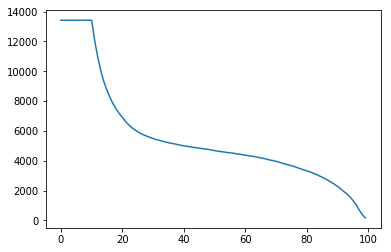

In [18]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.plot([len(selected[selected.score > i]) for i in np.arange(0, 100)]);

In [19]:
print('No. of pools detected: ', len(selected[selected.score > 30]))

No. of pools detected:  5486


In [20]:
gis = GIS('https://deldev.maps.arcgis.com', 'demos_deldev', os.environ.get('DEMOPWD'))

In [21]:
pools = gis.content.import_data(selected, title='Pools in Redlands', tags='deeplearning')    
pools

<Item title:"Pools in Redlands" type:Feature Layer Collection owner:demos_deldev>

In [23]:
aoi_parcels = parcels.layers[0]
# pools = gis.content.get('6531c1e0d3234bb8a7c630302060a7c3')

In [39]:
from arcgis.mapping.renderer import generate_renderer

parcels = gis.content.get('fd0ab9419c234a4783da3466e804ce85')
parcels_with_unauthorized_pools = gis.content.get('d02e7a19fdeb46c5ace518535c0c9646')
detected_pools = gis.content.get('dae7b7c72e0c41f88852597ec517fca1')

def show_results(rm):
    red_renderer = generate_renderer('Polygon', symbol_type='simple', symbol_style='s',
                                     colors=[[0,0,0,0]], outline_color=[255,0,0,255], line_width=2.25)
    rm.add_layer(parcels, {"renderer":{"type":"uniqueValue","field1":"pool_","defaultSymbol":{"color":None,"outline":{"color":[153,153,153,255],"width":0.75,"type":"esriSLS","style":"esriSLSSolid"},"type":"esriSFS","style":"esriSFSSolid"},"defaultLabel":"Other","uniqueValueInfos":[{"value":"UNH","symbol":{"color":None,"outline":{"color":[0,255,255,255],"width":1.125,"type":"esriSLS","style":"esriSLSSolid"},"type":"esriSFS","style":"esriSFSSolid"},"label":"UNH"},{"value":"HEA","symbol":{"color":None,"outline":{"color":[0,255,255,255],"width":1.125,"type":"esriSLS","style":"esriSLSSolid"},"type":"esriSFS","style":"esriSFSSolid"},"label":"HEA"}]}})
    rm.add_layer(parcels_with_unauthorized_pools, {'renderer': red_renderer})
    #result_map.add_layer(detected_pools, {'renderer': { "type": "uniqueValue", "field1": None,"valueExpression": "if (($feature.pool_ == 'UNH') || ($feature.pool_ == 'HEA')) {\n    return \"Authorized Pool\";\n} else if ($feature.score > 75) {\n    return \"Unauthorized Pool (high confidence)\";\n} else  if ($feature.score > 60) {\n    return \"Unauthorized Pool (low confidence)\";\n}","valueExpressionTitle": "Custom","uniqueValueInfos": [{"value":"Authorized Pool","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowYellowCenter.png","width":31.5,"height":31.5},"label":"Authorized Pool"},{"value":"Unauthorized Pool (high confidence)","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowRedCenter.png","width":31.5,"height":31.5},"label":"Unauthorized Pool (high confidence)"},{"value":"Unauthorized Pool (low confidence)","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowOrangeCenter.png","width":31.5,"height":31.5},"label":"Unauthorized Pool (low confidence)"}]}})
    
arcade_renderer = {'renderer': { "type": "uniqueValue", "field1": None,"valueExpression": "if (($feature.pool_ == 'UNH') || ($feature.pool_ == 'HEA')) {\n    return \"Authorized Pool\";\n} else if ($feature.score > 75) {\n    return \"Unauthorized Pool (high confidence)\";\n} else  if ($feature.score > 60) {\n    return \"Unauthorized Pool (low confidence)\";\n}","valueExpressionTitle": "Custom","uniqueValueInfos": [{"value":"Authorized Pool","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowYellowCenter.png","width":31.5,"height":31.5},"label":"Authorized Pool"},{"value":"Unauthorized Pool (high confidence)","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowRedCenter.png","width":31.5,"height":31.5},"label":"Unauthorized Pool (high confidence)"},{"value":"Unauthorized Pool (low confidence)","symbol":{"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://rohitgeo.github.io/images/ArrowOrangeCenter.png","width":31.5,"height":31.5},"label":"Unauthorized Pool (low confidence)"}]}}
   

### Analysis: Join pools to residential parcels

<Item title:"Parcels_In_Redlands" type:Feature Layer Collection owner:demos_deldev>
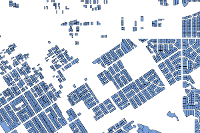

In [22]:
parcels = gis.content.get('fd0ab9419c234a4783da3466e804ce85') # Parcels_In_Redlands 
parcels

In [24]:
from arcgis.features.summarize_data import join_features

pools_within_parcels = join_features(pools, aoi_parcels,
                                           join_operation='JoinOneToMany',
                                           spatial_relationship='intersects',
                                           output_name="Pools_Within_Parcels")
pools_within_parcels

<Item title:"Pools_Within_Parcels" type:Feature Layer Collection owner:demos_deldev>

#### Find pool with highest score in parcel

In [25]:
df = pools_within_parcels.layers[0].query().df
df.to_featureclass(r'inferencing', 'Pools_Within_Parcels.shp')

'inferencing/Pools_Within_Parcels.shp'

In [33]:
df = SpatialDataFrame.from_featureclass('inferencing/Pools_Within_Parcels.shp')

In [26]:
grouped = (df[(df['score'] > 30) & (df['c_score'] > 50.0)].groupby(by='apn').apply(lambda x: x.loc[x.c_score.idxmax(), :]))
grouped.reset_index(drop=True, inplace=True)

temp = SpatialDataFrame(data=grouped)
SHAPE = temp['SHAPE'].copy()
del temp['SHAPE']
temp = temp.set_geometry(SHAPE)
temp.sr = {'wkid': 3857}

detected_pools = gis.content.import_data(temp, title='Detected Swimming Pools', tags='deeplearning')    
detected_pools

<Item title:"Detected Swimming Pools" type:Feature Layer Collection owner:demos_deldev>

In [9]:
unauthorized_pools = detected_pools.layers[0]
unauthorized_pools.filter = "(pool_ <> 'HEA') AND (pool_ <> 'UNH') AND (score > 60)"

### Analysis: Find parcels with unassessed swimming pools

In [28]:
parcels_with_unassessed_pools = join_features(aoi_parcels, unassessed_pools, 
                                    join_operation='JoinOneToMany',
                                    spatial_relationship='intersects',
                                    output_name="Parcels_With_Unassessed_Pools")
parcels_with_unassessed_pools

<Item title:"Parcels_With_Unauthorized_Pools" type:Feature Layer Collection owner:demos_deldev>

### Create web map

In [35]:
result_map = gis.map('Redlands County Club, Redlands, CA', zoomlevel=17)
result_map.basemap = 'satellite'
result_map

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oc…

In [36]:
show_results(result_map)

In [81]:
webmap_item = result_map.save({
    'title': 'Detected swimming pools',
    'tags': 'deeplearning',
    'snippet': 'Swimming pools detected using deep learning'
})
webmap_item

<Item title:"Detected swimming pools" type:Web Map owner:demos_deldev>

# Generate Report

In [12]:
parcel_df = parcels_with_unauthorized_pools.layers[0].query().df

In [14]:
parcel_df[['apn', 'ownername', 'pool_', 'spa_', 'taxstatus', 'landvalue', 'improvemen']]

,apn,ownername,pool_,spa_,taxstatus,landvalue,improvemen
0,017304123,"SEDGWICK, WILLIAM A TRUST EST OF",,,ASSESSED BY COUNTY,"5,027","12,116"
1,017021117,"AYON, JOSE RAMON",,,ASSESSED BY COUNTY,"51,377","154,129"
2,017319122,"ROBLES, MICHAEL",,,ASSESSED BY COUNTY,"113,178","237,673"
3,016731330,"CALEY, JAMES P",,,ASSESSED BY COUNTY,"57,800","136,300"
4,016731303,"RAZO, MARGARITA",,,ASSESSED BY COUNTY,"50,050","116,784"
5,016731301,"FITZPATRICK, GARY L",,,ASSESSED BY COUNTY,"22,476","76,242"
6,017221219,"WHITTEMORE, JAMES B III",,,ASSESSED BY COUNTY,"30,027","117,537"
7,017328110,"TARTONI, CHRISTOPHER W",,,ASSESSED BY COUNTY,"54,114","162,340"
8,017301231,REY PROPERTIES,,,ASSESSED BY COUNTY,"55,479","149,794"
9,121205167,DESPAIN LIVING TRUST 3/16/18,,,ASSESSED BY COUNTY,"139,800","327,000"


## Looking in closer

In [40]:
m = gis.map('1418 Sterling Rd, Redlands, CA')
m.basemap = 'satellite'
m

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oc…

In [41]:
show_results(m)
m.add_layer(detected_pools, arcade_renderer)

# Zombie pools

## Classify pools as 'clean' or 'green' using deep learning

In [97]:
folder = 'inferencing/cleangreen_2706'

<Item title:"World Imagery" type:Map Image Layer owner:esri>
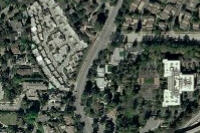

In [149]:
imagery = gis.content.get('10df2279f9684e4a9f6a7f08febac2a9')
imagery

In [150]:
imagery_lyr = MapImageLayer.fromitem(imagery)

In [151]:
for index, row in df.iterrows():
    img_name = 'img' + str(df.loc[index,'parcelnumb']).zfill(4)# index).zfill(4)
    try:
        g = row['SHAPE']
        x, y = g['x'] - 7, g['y'] - 7
        ext = (x, y, x + 14, y + 14)
        if not os.path.isfile(folder + '/' + img_name + '.jpg'):
            imagery_lyr.export_map(ext, 102100, '224,224', f='image', format='jpg',
                    save_folder=folder, save_file='{}.jpg'.format(img_name))
            print(f'{img_name} downloaded..')    
    except Exception as e:
        print('Error {} getting {}'.format(e,img_name))

img016706106 downloaded..
img016708115 downloaded..
img016708119 downloaded..
img016708126 downloaded..
img016708144 downloaded..
img016711123 downloaded..
img016711209 downloaded..
img016711221 downloaded..
img016711229 downloaded..
img016711307 downloaded..
img016711415 downloaded..
img016712103 downloaded..
img016712124 downloaded..
img016712203 downloaded..
img016713203 downloaded..
img016713309 downloaded..
img016713312 downloaded..
img016713415 downloaded..
img016713417 downloaded..
img016718110 downloaded..
img016718123 downloaded..
img016718208 downloaded..
img016718218 downloaded..
img016719124 downloaded..
img016720116 downloaded..
img016720149 downloaded..
img016721115 downloaded..
img016721119 downloaded..
img016723221 downloaded..
img016726132 downloaded..
img016726169 downloaded..
img016727115 downloaded..
img016728127 downloaded..
img016728201 downloaded..
img016728213 downloaded..
img016728302 downloaded..
img016728323 downloaded..
img016729311 downloaded..
img016731211

img016869161 downloaded..
img016869162 downloaded..
img016869164 downloaded..
img016870101 downloaded..
img016870103 downloaded..
img016870104 downloaded..
img016870109 downloaded..
img016870115 downloaded..
img016870117 downloaded..
img016870119 downloaded..
img016870123 downloaded..
img016870124 downloaded..
img016870129 downloaded..
img016870130 downloaded..
img016870132 downloaded..
img016870138 downloaded..
img016870139 downloaded..
img016870140 downloaded..
img016870142 downloaded..
img016870143 downloaded..
img016870153 downloaded..
img016873102 downloaded..
img016873103 downloaded..
img016873106 downloaded..
img016873107 downloaded..
img016873115 downloaded..
img016873117 downloaded..
img016873119 downloaded..
img016874101 downloaded..
img016874106 downloaded..
img016874110 downloaded..
img016874111 downloaded..
img016874114 downloaded..
img016874116 downloaded..
img016874119 downloaded..
img016874121 downloaded..
img016874122 downloaded..
img016874124 downloaded..
img016874128

img017108609 downloaded..
img017117120 downloaded..
img017120105 downloaded..
img017120108 downloaded..
img017120320 downloaded..
img017120340 downloaded..
img017122303 downloaded..
img017122321 downloaded..
img017123103 downloaded..
img017123108 downloaded..
img017123222 downloaded..
img017124115 downloaded..
img017124302 downloaded..
img017124309 downloaded..
img017124402 downloaded..
img017131206 downloaded..
img017131208 downloaded..
img017131210 downloaded..
img017131218 downloaded..
img017131320 downloaded..
img017132106 downloaded..
img017132208 downloaded..
img017132215 downloaded..
img017135136 downloaded..
img017135201 downloaded..
img017135204 downloaded..
img017135212 downloaded..
img017135219 downloaded..
img017135304 downloaded..
img017135311 downloaded..
img017135312 downloaded..
img017136120 downloaded..
img017136207 downloaded..
img017136217 downloaded..
img017136302 downloaded..
img017201318 downloaded..
img017201320 downloaded..
img017201327 downloaded..
img017201328

img017227321 downloaded..
img017227325 downloaded..
img017227407 downloaded..
img017227415 downloaded..
img017228104 downloaded..
img017228105 downloaded..
img017228122 downloaded..
img017228145 downloaded..
img017228147 downloaded..
img017228204 downloaded..
img017228206 downloaded..
img017229106 downloaded..
img017229109 downloaded..
img017229124 downloaded..
img017229128 downloaded..
img017229131 downloaded..
img017229134 downloaded..
img017229135 downloaded..
img017229204 downloaded..
img017229205 downloaded..
img017229206 downloaded..
img017230109 downloaded..
img017230111 downloaded..
img017230115 downloaded..
img017230117 downloaded..
img017231107 downloaded..
img017231108 downloaded..
img017231109 downloaded..
img017231110 downloaded..
img017231113 downloaded..
img017231114 downloaded..
img017231118 downloaded..
img017231121 downloaded..
img017231123 downloaded..
img017231125 downloaded..
img017231132 downloaded..
img017231133 downloaded..
img017231136 downloaded..
img017232121

img017303303 downloaded..
img017304101 downloaded..
img017304104 downloaded..
img017304109 downloaded..
img017304114 downloaded..
img017304119 downloaded..
img017304120 downloaded..
img017304121 downloaded..
img017304123 downloaded..
img017304206 downloaded..
img017304208 downloaded..
img017304213 downloaded..
img017304306 downloaded..
img017304312 downloaded..
img017304318 downloaded..
img017305116 downloaded..
img017305242 downloaded..
img017306103 downloaded..
img017306129 downloaded..
img017308404 downloaded..
img017308409 downloaded..
img017311106 downloaded..
img017311117 downloaded..
img017311313 downloaded..
img017311317 downloaded..
img017311324 downloaded..
img017311401 downloaded..
img017311405 downloaded..
img017311415 downloaded..
img017312105 downloaded..
img017312207 downloaded..
img017312208 downloaded..
img017312316 downloaded..
img017313127 downloaded..
img017313139 downloaded..
img017313140 downloaded..
img017313143 downloaded..
img017313146 downloaded..
img017313150

img017345133 downloaded..
img017345134 downloaded..
img017345135 downloaded..
img017345137 downloaded..
img017345138 downloaded..
img017345143 downloaded..
img017345154 downloaded..
img017345155 downloaded..
img017345158 downloaded..
img017346102 downloaded..
img017346104 downloaded..
img017346105 downloaded..
img017346111 downloaded..
img017346113 downloaded..
img017346116 downloaded..
img017346119 downloaded..
img017346123 downloaded..
img017346124 downloaded..
img017346125 downloaded..
img017346126 downloaded..
img017347104 downloaded..
img017347105 downloaded..
img017347108 downloaded..
img017347111 downloaded..
img017347116 downloaded..
img017347117 downloaded..
img017347120 downloaded..
img017347121 downloaded..
img017347123 downloaded..
img017347124 downloaded..
img017347126 downloaded..
img017347127 downloaded..
img017347128 downloaded..
img017349110 downloaded..
img017349117 downloaded..
img017349118 downloaded..
img017349124 downloaded..
img017349129 downloaded..
img017349131

img017434105 downloaded..
img017434106 downloaded..
img017434107 downloaded..
img017434108 downloaded..
img017434109 downloaded..
img017434110 downloaded..
img017434111 downloaded..
img017434112 downloaded..
img017434113 downloaded..
img017434115 downloaded..
img017434116 downloaded..
img017434117 downloaded..
img017434118 downloaded..
img017434120 downloaded..
img017434121 downloaded..
img017434124 downloaded..
img017435113 downloaded..
img017435114 downloaded..
img017435124 downloaded..
img017435125 downloaded..
img017435127 downloaded..
img017435128 downloaded..
img017435129 downloaded..
img017435130 downloaded..
img017435132 downloaded..
img017435136 downloaded..
img017435203 downloaded..
img017435204 downloaded..
img017435209 downloaded..
img017435218 downloaded..
img017436101 downloaded..
img017436102 downloaded..
img017436103 downloaded..
img017436104 downloaded..
img017436106 downloaded..
img017436107 downloaded..
img017436108 downloaded..
img017436109 downloaded..
img017436111

img017463125 downloaded..
img017463126 downloaded..
img017463128 downloaded..
img017463129 downloaded..
img017463131 downloaded..
img017463133 downloaded..
img017463137 downloaded..
img017463138 downloaded..
img017463139 downloaded..
img017463140 downloaded..
img017463141 downloaded..
img017463144 downloaded..
img017463145 downloaded..
img017463147 downloaded..
img017463151 downloaded..
img017463152 downloaded..
img017463154 downloaded..
img017463156 downloaded..
img017463157 downloaded..
img017463164 downloaded..
img017464101 downloaded..
img017464104 downloaded..
img017464105 downloaded..
img017464107 downloaded..
img017464111 downloaded..
img017465103 downloaded..
img017465104 downloaded..
img017465105 downloaded..
img017465106 downloaded..
img017465108 downloaded..
img017465110 downloaded..
img017465114 downloaded..
img017465116 downloaded..
img017465117 downloaded..
img017465121 downloaded..
img017465122 downloaded..
img017465125 downloaded..
img017465126 downloaded..
img017465127

img017534103 downloaded..
img017534104 downloaded..
img017534105 downloaded..
img017535102 downloaded..
img017535103 downloaded..
img017535104 downloaded..
img017535106 downloaded..
img017535108 downloaded..
img017535109 downloaded..
img017535110 downloaded..
img017535111 downloaded..
img017535115 downloaded..
img017535120 downloaded..
img017535122 downloaded..
img017535125 downloaded..
img017535127 downloaded..
img017535128 downloaded..
img017535131 downloaded..
img017535135 downloaded..
img017535136 downloaded..
img017535142 downloaded..
img017535143 downloaded..
img017535153 downloaded..
img017536101 downloaded..
img017536201 downloaded..
img017536404 downloaded..
img017536501 downloaded..
img017536503 downloaded..
img017536504 downloaded..
img017536505 downloaded..
img017536506 downloaded..
img017536507 downloaded..
img017536508 downloaded..
img017536510 downloaded..
img017536511 downloaded..
img017536512 downloaded..
img017536513 downloaded..
img017536514 downloaded..
img017536601

img017610353 downloaded..
img017610357 downloaded..
img017610359 downloaded..
img017610361 downloaded..
img017611101 downloaded..
img017611102 downloaded..
img017613211 downloaded..
img017613214 downloaded..
img017613217 downloaded..
img017613218 downloaded..
img017613219 downloaded..
img017613314 downloaded..
img017613316 downloaded..
img017613317 downloaded..
img017613322 downloaded..
img017613411 downloaded..
img017613412 downloaded..
img017613513 downloaded..
img017613517 downloaded..
img017613518 downloaded..
img017614213 downloaded..
img017614216 downloaded..
img017615114 downloaded..
img017615115 downloaded..
img017615202 downloaded..
img017615204 downloaded..
img017615205 downloaded..
img017615206 downloaded..
img017615210 downloaded..
img017615218 downloaded..
img017615220 downloaded..
img017615223 downloaded..
img017615224 downloaded..
img017615302 downloaded..
img017615306 downloaded..
img017615310 downloaded..
img017615336 downloaded..
img017615337 downloaded..
img017615338

img017639104 downloaded..
img017639106 downloaded..
img017639107 downloaded..
img017639110 downloaded..
img017639111 downloaded..
img017639112 downloaded..
img017639114 downloaded..
img017639117 downloaded..
img017639118 downloaded..
img017639201 downloaded..
img017639203 downloaded..
img017640104 downloaded..
img017640106 downloaded..
img017640107 downloaded..
img017640113 downloaded..
img017640114 downloaded..
img017640202 downloaded..
img017640205 downloaded..
img017640210 downloaded..
img017640211 downloaded..
img017641103 downloaded..
img017641105 downloaded..
img017641106 downloaded..
img017641107 downloaded..
img017641108 downloaded..
img017641110 downloaded..
img017641111 downloaded..
img017641114 downloaded..
img017641116 downloaded..
img017641117 downloaded..
img017641118 downloaded..
img017641120 downloaded..
img017641121 downloaded..
img017641123 downloaded..
img017642103 downloaded..
img017642104 downloaded..
img017642107 downloaded..
img017642110 downloaded..
img017642112

Error HTTP Error 500: Internal Server Error getting img030004106
Error HTTP Error 500: Internal Server Error getting img030004107
Error HTTP Error 500: Internal Server Error getting img030004109
Error HTTP Error 500: Internal Server Error getting img030004110
Error HTTP Error 500: Internal Server Error getting img030004113
Error HTTP Error 500: Internal Server Error getting img030004116
Error HTTP Error 500: Internal Server Error getting img030004117
Error HTTP Error 500: Internal Server Error getting img030004118
Error HTTP Error 500: Internal Server Error getting img030004120
Error HTTP Error 500: Internal Server Error getting img030004123
Error HTTP Error 500: Internal Server Error getting img030005101
Error HTTP Error 500: Internal Server Error getting img030005103
Error HTTP Error 500: Internal Server Error getting img030005108
Error HTTP Error 500: Internal Server Error getting img030005109
Error HTTP Error 500: Internal Server Error getting img030005112
Error HTTP Error 500: Int

img030037113 downloaded..
img030037114 downloaded..
img030037115 downloaded..
img030037116 downloaded..
img030037117 downloaded..
img030037201 downloaded..
img030037202 downloaded..
img030037204 downloaded..
img030037205 downloaded..
img030037206 downloaded..
img030037207 downloaded..
img030037208 downloaded..
img030037209 downloaded..
img030037210 downloaded..
img030037301 downloaded..
img030037405 downloaded..
img030037501 downloaded..
img030038102 downloaded..
img030038103 downloaded..
img030038104 downloaded..
img030038105 downloaded..
img030038106 downloaded..
Error HTTP Error 500: Internal Server Error getting img030038210
Error HTTP Error 500: Internal Server Error getting img030038215
img030038224 downloaded..
img030039203 downloaded..
img030039302 downloaded..
img030039303 downloaded..
img030039401 downloaded..
img030039402 downloaded..
img030039404 downloaded..
img030039410 downloaded..
Error HTTP Error 500: Internal Server Error getting img030039411
img030040101 downloaded..

img121215132 downloaded..
img121215136 downloaded..
img121215145 downloaded..
img121215153 downloaded..
img121215155 downloaded..
img121215156 downloaded..
img121215161 downloaded..
img121216102 downloaded..
img121216106 downloaded..
img121218105 downloaded..
img121218109 downloaded..
img121218112 downloaded..
img121218115 downloaded..
img121218129 downloaded..
img121219102 downloaded..
img121219117 downloaded..
img121219123 downloaded..
img121219124 downloaded..
img121219152 downloaded..
img121219154 downloaded..
img121219160 downloaded..
img121219161 downloaded..
img121219162 downloaded..
img121219178 downloaded..
img121220109 downloaded..
img121220112 downloaded..
img121220113 downloaded..
img121220118 downloaded..
img121220119 downloaded..
img121220121 downloaded..
img121220123 downloaded..
img121220126 downloaded..
img121222135 downloaded..
img121222146 downloaded..
img121222156 downloaded..
img121224102 downloaded..
img121224108 downloaded..
img121224112 downloaded..
img121224115

### Load model for classifying zombie pools

In [82]:
model_path = 'clean_green.h5'

In [83]:
models = ConvnetBuilder(resnet34, 2, False, False, pretrained=True)
clean_green_model = models.model
clean_green_model = load_model(clean_green_model, model_path)

In [84]:
clean_green_model.eval();

In [85]:
cleangreen_scores = {}

for index, row in df.iterrows():
    
    try:
        img_name = 'img' + str(index).zfill(4) + '.jpg'
        img_path = folder + '/' + img_name
        img = np.array(Image.open(img_path))
        score = float(predict_classf(clean_green_model,
                               norm(img).transpose(2, 0, 1))[0])
        print(img_name, score)
        cleangreen_scores[index] = score
        
    except Exception as e:
        cleangreen_scores[index] = -1
        print(img_name, '-1') #'0.0123 - ')

img0000.jpg 2.2184494241628272e-07
img0001.jpg -1
img0002.jpg 1.5013942311625783e-09
img0003.jpg 6.998865956120426e-06
img0004.jpg 3.947612459143102e-09
img0005.jpg 5.994645135842802e-08
img0006.jpg 7.355306763656699e-08
img0007.jpg 0.4059678912162781
img0008.jpg 1.8797290977090597e-05
img0009.jpg 1.4384631867869757e-05
img0010.jpg 5.261817477730801e-06
img0011.jpg 0.00026494188932701945
img0012.jpg 0.9999990463256836
img0013.jpg -1
img0014.jpg 1.0227958000541548e-06
img0015.jpg 1.4038592780707404e-05
img0016.jpg 0.029702335596084595
img0017.jpg 1.8205688320449553e-05
img0018.jpg 5.431729732663371e-06
img0019.jpg 0.010224565863609314
img0020.jpg 0.0006251343875192106
img0021.jpg 1.140426419965479e-07
img0022.jpg 2.9141965569579042e-06
img0023.jpg 0.12008912116289139
img0024.jpg 8.699009512724842e-09
img0025.jpg 1.2086854894732824e-07
img0026.jpg 0.0006222599768079817
img0027.jpg 8.439764314971399e-06
img0028.jpg 9.220602947834777e-09
img0029.jpg 1.324865905871775e-07
img0030.jpg 0.9774

img0273.jpg 6.592095451196656e-05
img0274.jpg -1
img0275.jpg 7.808249938534573e-05
img0276.jpg 0.0011013745097443461
img0277.jpg 0.0003075209097005427
img0278.jpg 0.771122395992279
img0279.jpg 7.03066575624689e-07
img0280.jpg 0.003955470398068428
img0281.jpg 1.4737589708602172e-06
img0282.jpg 1.5905994743548035e-08
img0283.jpg 0.08022870123386383
img0284.jpg 0.01959073543548584
img0285.jpg 0.0030107074417173862
img0286.jpg 1.9768391368302218e-08
img0287.jpg 0.0007721194415353239
img0288.jpg 6.431926067307359e-07
img0289.jpg -1
img0290.jpg 0.004676874727010727
img0291.jpg 5.503299689735286e-06
img0292.jpg 0.03799794614315033
img0293.jpg 8.073672688624356e-06
img0294.jpg 6.398280305575099e-08
img0295.jpg 0.0746532529592514
img0296.jpg 9.758520718605723e-06
img0297.jpg 5.496394237525237e-07
img0298.jpg 1.844217513280455e-05
img0299.jpg 3.269685112172738e-05
img0300.jpg 6.328501331154257e-05
img0301.jpg 0.003370331134647131
img0302.jpg 1.0388192777099903e-06
img0303.jpg 0.00044522262760438

img0548.jpg 0.010040028020739555
img0549.jpg 0.0015283109387382865
img0550.jpg 0.015434129163622856
img0551.jpg 0.7633821368217468
img0552.jpg 0.02786601148545742
img0553.jpg 5.258471446722979e-06
img0554.jpg 0.0005749132833443582
img0555.jpg -1
img0556.jpg 0.016020214185118675
img0557.jpg 0.00021247057884465903
img0558.jpg 0.0001925308897625655
img0559.jpg 0.6110743284225464
img0560.jpg 0.8249045610427856
img0561.jpg 0.25262337923049927
img0562.jpg 0.08946395665407181
img0563.jpg -1
img0564.jpg 0.9892286062240601
img0565.jpg 0.0007858241442590952
img0566.jpg 2.7887888791156e-05
img0567.jpg 0.8090327978134155
img0568.jpg 0.8850143551826477
img0569.jpg 0.000102947473351378
img0570.jpg 0.06155281141400337
img0571.jpg 0.879506528377533
img0572.jpg 0.0003993597929365933
img0573.jpg -1
img0574.jpg 0.003173254895955324
img0575.jpg 0.003996922634541988
img0576.jpg -1
img0577.jpg 0.12041366845369339
img0578.jpg 0.017661865800619125
img0579.jpg 0.0011439361842349172
img0580.jpg 0.03453277796506

img0820.jpg 8.110730975730007e-10
img0821.jpg 4.6735101477679564e-07
img0822.jpg 3.866566112264991e-05
img0823.jpg 4.6326894675985386e-07
img0824.jpg 0.9191706776618958
img0825.jpg 9.839579462322945e-08
img0826.jpg 8.304916576662436e-08
img0827.jpg 1.613887775420153e-06
img0828.jpg 1.828862696129363e-05
img0829.jpg 1.0147202829102753e-06
img0830.jpg 0.0006816067616455257
img0831.jpg 8.181180533028964e-07
img0832.jpg 2.6349962922722625e-07
img0833.jpg 3.248552786772052e-07
img0834.jpg 1.1242747177675483e-07
img0835.jpg 0.0019487228710204363
img0836.jpg 1.9837382296827855e-06
img0837.jpg 0.003187023801729083
img0838.jpg 0.00018938496941700578
img0839.jpg 4.338386133895256e-06
img0840.jpg 6.018179306011007e-07
img0841.jpg 3.56736578055461e-08
img0842.jpg 0.00043476061546243727
img0843.jpg 2.8388660311406966e-09
img0844.jpg 3.102173877778114e-07
img0845.jpg 6.280381370515897e-08
img0846.jpg 1.7616082459426252e-07
img0847.jpg 1.961776433745399e-05
img0848.jpg 5.352220000531815e-07
img0849.j

img1085.jpg 0.9998421669006348
img1086.jpg 9.667911626820569e-07
img1087.jpg -1
img1088.jpg -1
img1089.jpg 1.4198271856002975e-06
img1090.jpg 2.598698301881086e-05
img1091.jpg 1.8406207402676955e-07
img1092.jpg 4.070393515576143e-06
img1093.jpg 1.2660863468738626e-09
img1094.jpg 0.00021823016868438572
img1095.jpg 2.785548360861867e-07
img1096.jpg 0.00039473100332543254
img1097.jpg 0.0036247209645807743
img1098.jpg 5.0848415412474424e-05
img1099.jpg 2.1594999566332262e-07
img1100.jpg 6.06021970384063e-08
img1101.jpg 2.0837718217592283e-09
img1102.jpg 7.001742119427945e-08
img1103.jpg 1.0213362656941172e-05
img1104.jpg 5.79046943727235e-09
img1105.jpg 1.3442300428323506e-07
img1106.jpg 0.8537740111351013
img1107.jpg 2.0690353267127648e-05
img1108.jpg 0.00556059880182147
img1109.jpg 0.006113206036388874
img1110.jpg 1.3844214663549792e-07
img1111.jpg 3.674936669995077e-05
img1112.jpg 0.007523629814386368
img1113.jpg 2.1593466499325586e-06
img1114.jpg 1.7538912970849196e-06
img1115.jpg 2.49

img1346.jpg 0.08906052261590958
img1347.jpg 2.403297730779741e-05
img1348.jpg 8.608789357822388e-05
img1349.jpg 7.733525535513763e-07
img1350.jpg 1.8449660501573817e-06
img1351.jpg 1.0301156180503312e-05
img1352.jpg 0.0030208369717001915
img1353.jpg 2.2037572762201307e-06
img1354.jpg 1.4741904124093708e-06
img1355.jpg 2.153513207758806e-07
img1356.jpg 1.5790743645993643e-07
img1357.jpg 1.4561446732841432e-06
img1358.jpg 1.797849290596787e-05
img1359.jpg 4.995971266907873e-06
img1360.jpg 1.7742873126280756e-07
img1361.jpg 4.033361449273798e-07
img1362.jpg 6.071714778954629e-06
img1363.jpg 1.7489215053956286e-07
img1364.jpg 3.148926771245897e-05
img1365.jpg 2.4093651518342085e-09
img1366.jpg 0.0009837920079007745
img1367.jpg 0.3040974736213684
img1368.jpg 1.29651459701563e-06
img1369.jpg 0.0011528751347213984
img1370.jpg 0.001147997798398137
img1371.jpg 0.00026312589761801064
img1372.jpg 1.9803828763542697e-06
img1373.jpg 3.000551623699721e-05
img1374.jpg 5.137148946232628e-06
img1375.jp

img1615.jpg 1.213169889524579e-05
img1616.jpg 0.5192970633506775
img1617.jpg 5.8539033176430166e-08
img1618.jpg 0.006586019415408373
img1619.jpg 5.818063755214098e-07
img1620.jpg 2.6306490781280445e-06
img1621.jpg 1.4535762815626185e-08
img1622.jpg 2.9295684726093896e-05
img1623.jpg 1.2367422641546e-07
img1624.jpg 6.707073680445319e-06
img1625.jpg 1.1125582204840612e-05
img1626.jpg 4.893795630778186e-05
img1627.jpg 6.393130024662241e-05
img1628.jpg 0.7338401675224304
img1629.jpg 5.559092187468195e-06
img1630.jpg 1.3112495977907201e-08
img1631.jpg 0.08475969731807709
img1632.jpg 2.498900721548125e-05
img1633.jpg 4.606746642821236e-06
img1634.jpg 6.2561894083046354e-06
img1635.jpg 4.416748652147362e-06
img1636.jpg 0.0001614970387890935
img1637.jpg 0.05761221423745155
img1638.jpg -1
img1639.jpg 2.3511104245699244e-06
img1640.jpg 0.9959164261817932
img1641.jpg 2.0556455638143234e-05
img1642.jpg 1.053200637812779e-08
img1643.jpg 1.0315637155144941e-05
img1644.jpg 2.3155097395033408e-08
img1

img1878.jpg 2.4852537805486463e-09
img1879.jpg 1.3457681234285701e-05
img1880.jpg 0.07677207142114639
img1881.jpg 0.00024015209055505693
img1882.jpg 1.8666266896616435e-06
img1883.jpg 5.941777999396436e-05
img1884.jpg 4.039297323288338e-07
img1885.jpg 5.7513563660904765e-05
img1886.jpg 0.0015272547025233507
img1887.jpg 0.0002465818542987108
img1888.jpg 2.0739472361697153e-08
img1889.jpg 1.556505412736442e-05
img1890.jpg 6.7898923816756e-07
img1891.jpg 0.1714632660150528
img1892.jpg 4.2880776163656265e-05
img1893.jpg 9.310775567428209e-06
img1894.jpg 1.375111310153443e-06
img1895.jpg 9.022853646456497e-07
img1896.jpg 8.430447451246437e-10
img1897.jpg 2.4225166271207854e-05
img1898.jpg 1.844187522692664e-07
img1899.jpg 0.0037015846464782953
img1900.jpg 1.9116180283162976e-06
img1901.jpg 1.9033492208109237e-05
img1902.jpg 4.903778858533769e-07
img1903.jpg 3.938604464792661e-08
img1904.jpg 0.0012758567463606596
img1905.jpg 1.2757531067109085e-06
img1906.jpg 1.525953848613426e-06
img1907.jp

img2128.jpg 1.3669053444687052e-08
img2129.jpg 0.016709549352526665
img2130.jpg 7.925789873297617e-07
img2131.jpg 2.6796601559908595e-06
img2132.jpg 2.020443389483262e-05
img2133.jpg 3.2364139315177454e-06
img2134.jpg 1.2221053680150362e-07
img2135.jpg -1
img2136.jpg 6.207767000887543e-05
img2137.jpg 0.0025326877366751432
img2138.jpg 5.0803530029952526e-05
img2139.jpg 1.0892512364080176e-05
img2140.jpg -1
img2141.jpg 4.0881891621991073e-11
img2142.jpg -1
img2143.jpg 2.247851540460033e-07
img2144.jpg 3.810887960753462e-07
img2145.jpg 0.0002507850294932723
img2146.jpg 1.9807825083262287e-05
img2147.jpg 0.002488676691427827
img2148.jpg 3.8326837170643557e-07
img2149.jpg 0.004972846247255802
img2150.jpg 0.00048256057198159397
img2151.jpg 1.69249676673644e-06
img2152.jpg 8.792788321443368e-06
img2153.jpg 4.345605702837929e-05
img2154.jpg 1.1651040040305816e-05
img2155.jpg 2.1154222906716313e-07
img2156.jpg 0.00243509653955698
img2157.jpg 3.37715005116479e-06
img2158.jpg 1.283206893276656e-0

img2377.jpg 0.5565672516822815
img2378.jpg 3.048771475278045e-07
img2379.jpg 6.824914180469932e-06
img2380.jpg 0.00015158313908614218
img2381.jpg 0.7200560569763184
img2382.jpg 8.921234240233389e-08
img2383.jpg 0.004911300726234913
img2384.jpg 8.714736759429798e-05
img2385.jpg 9.433410923520569e-06
img2386.jpg 6.359959225932243e-10
img2387.jpg 4.524749783740845e-06
img2388.jpg 1.412562333769074e-08
img2389.jpg 3.820957772404654e-07
img2390.jpg 4.4355956561048515e-06
img2391.jpg 2.319928171345964e-06
img2392.jpg 9.183408110402524e-06
img2393.jpg 4.929640908812871e-06
img2394.jpg 1.2912246347696055e-06
img2395.jpg 1.63624598314982e-08
img2396.jpg 3.879731593769975e-06
img2397.jpg 4.264342715032399e-05
img2398.jpg -1
img2399.jpg 8.819758932077093e-07
img2400.jpg 1.1345532868745067e-07
img2401.jpg 0.0006698865909129381
img2402.jpg 6.513784569506242e-07
img2403.jpg 5.415558916865848e-05
img2404.jpg -1
img2405.jpg 0.03107135370373726
img2406.jpg 0.20974725484848022
img2407.jpg 1.506764078840

img2877.jpg 2.2866670690291357e-07
img2878.jpg 1.2465118288673693e-06
img2879.jpg 0.0031963882502168417
img2880.jpg 0.0786476656794548
img2881.jpg 0.00011848921712953597
img2882.jpg 2.0245826817699708e-05
img2883.jpg 1.825388949328044e-06
img2884.jpg 2.0237372154952027e-05
img2885.jpg 0.07115424424409866
img2886.jpg 0.00030287684057839215
img2887.jpg 1.1340775017742999e-05
img2888.jpg -1
img2889.jpg 0.08241745084524155
img2890.jpg 0.009396880865097046
img2891.jpg 4.0793845982989296e-05
img2892.jpg 0.05827582627534866
img2893.jpg 8.759861884755082e-06
img2894.jpg 0.010341139510273933
img2895.jpg 1.685077819502112e-07
img2896.jpg 7.233394967443019e-07
img2897.jpg 0.0005748524563387036
img2898.jpg 2.652633520483505e-05
img2899.jpg 8.289269999295357e-07
img2900.jpg 3.285336561020813e-06
img2901.jpg 2.0706540453829803e-05
img2902.jpg 5.22885193277034e-06
img2903.jpg 0.0022387958597391844
img2904.jpg 2.3967984361661365e-06
img2905.jpg 9.386194869875908e-05
img2906.jpg 0.009609964676201344
im

img3131.jpg 0.04387159273028374
img3132.jpg 0.5612925887107849
img3133.jpg 3.0036176212888677e-07
img3134.jpg 1.2936793325479812e-07
img3135.jpg 0.12937135994434357
img3136.jpg 3.1290778679249343e-06
img3137.jpg 0.0003236651828046888
img3138.jpg 2.0952140403096564e-05
img3139.jpg 0.002386434469372034
img3140.jpg 8.749125299800653e-06
img3141.jpg 9.468104078536044e-11
img3142.jpg 0.02147221378982067
img3143.jpg 3.815548410557312e-08
img3144.jpg 4.74746229883749e-06
img3145.jpg 6.574691360583529e-05
img3146.jpg 1.133801106334431e-06
img3147.jpg 1.3877810260964907e-06
img3148.jpg 0.0029370824340730906
img3149.jpg 2.1184789034123241e-07
img3150.jpg 0.9884173274040222
img3151.jpg 6.361480336636305e-05
img3152.jpg 4.517075012699934e-06
img3153.jpg 3.015331913047703e-06
img3154.jpg 1.4899094821885228e-05
img3155.jpg 0.0732806846499443
img3156.jpg 4.196785141630244e-07
img3157.jpg 2.5232393454643898e-06
img3158.jpg 1.112495056077023e-06
img3159.jpg 2.417846189928241e-08
img3160.jpg 2.889512407

img3385.jpg 2.4583117763654627e-08
img3386.jpg 0.0001934926403919235
img3387.jpg 1.6416558992204955e-06
img3388.jpg 6.022884946332852e-08
img3389.jpg 0.0534370131790638
img3390.jpg 4.775773413712159e-05
img3391.jpg 1.3693242983947584e-08
img3392.jpg 1.8053237127446664e-08
img3393.jpg 2.0128838968958007e-06
img3394.jpg 5.919812551269388e-08
img3395.jpg 7.436255600623554e-06
img3396.jpg -1
img3397.jpg 1.1870937299818252e-07
img3398.jpg 2.8124686650699005e-05
img3399.jpg 0.0017099548131227493
img3400.jpg 2.055534650935442e-06
img3401.jpg 9.269712997195256e-09
img3402.jpg 1.1580078535189386e-05
img3403.jpg 1.518287172075361e-05
img3404.jpg 5.763427452620817e-06
img3405.jpg 2.457595655869227e-07
img3406.jpg -1
img3407.jpg 0.0006172626744955778
img3408.jpg 2.5902537004185433e-07
img3409.jpg 6.814527296228334e-06
img3410.jpg 3.543334798905562e-07
img3411.jpg 1.776031922418042e-06
img3412.jpg 0.0005531555507332087
img3413.jpg 0.03178699314594269
img3414.jpg 0.0007052312721498311
img3415.jpg 0.

img3639.jpg 0.003672109916806221
img3640.jpg 7.726231160631869e-06
img3641.jpg 4.3052668274867756e-07
img3642.jpg 1.3440935617836658e-06
img3643.jpg 1.018892192838905e-09
img3644.jpg 3.1475843798034475e-07
img3645.jpg 1.8998579776052793e-07
img3646.jpg 0.0005330960266292095
img3647.jpg 8.922489413976109e-09
img3648.jpg 2.333828660994186e-06
img3649.jpg 0.9999866485595703
img3650.jpg 6.972211394895567e-06
img3651.jpg -1
img3652.jpg 3.956013188144425e-07
img3653.jpg 4.5404300408335985e-07
img3654.jpg 3.6347471450426383e-06
img3655.jpg 1.820163397781016e-08
img3656.jpg 3.5477100368552783e-07
img3657.jpg 2.2140964119898854e-06
img3658.jpg 1.0160449619434075e-06
img3659.jpg 2.1056022887933068e-05
img3660.jpg 2.6597968272312755e-09
img3661.jpg 0.6451655626296997
img3662.jpg 2.911264709837269e-05
img3663.jpg 3.7918987800367177e-05
img3664.jpg 0.0007355083362199366
img3665.jpg 3.2068961445475e-05
img3666.jpg 8.156033182160627e-09
img3667.jpg 0.0017473729094490409
img3668.jpg 2.5794761313591152

img3893.jpg 1.1042971692631909e-07
img3894.jpg 8.459123250759149e-07
img3895.jpg 1.0053805681309314e-06
img3896.jpg 0.05949859321117401
img3897.jpg 1.434035468150796e-08
img3898.jpg 3.7869099287490826e-06
img3899.jpg 1.2052181546096108e-06
img3900.jpg 2.3685234395998123e-07
img3901.jpg 8.918414664549346e-07
img3902.jpg 0.0005898814997635782
img3903.jpg 5.271043391985586e-06
img3904.jpg 0.000596956699155271
img3905.jpg 1.1145717508043163e-05
img3906.jpg 1.0778826720070356e-08
img3907.jpg 0.007433196995407343
img3908.jpg 1.290612362936372e-05
img3909.jpg 5.550923560804222e-06
img3910.jpg 4.592115874402225e-05
img3911.jpg 0.001964972820132971
img3912.jpg 0.0014991983771324158
img3913.jpg 0.0044387043453752995
img3914.jpg 4.437901157672286e-10
img3915.jpg 0.00014384488167706877
img3916.jpg 1.0553247165034918e-07
img3917.jpg 5.459157250697899e-07
img3918.jpg 1.0629070857248735e-05
img3919.jpg 3.367090812389506e-06
img3920.jpg 0.00023277360014617443
img3921.jpg 0.002378095407038927
img3922.j

img4148.jpg 0.010195685550570488
img4149.jpg 0.05636846274137497
img4150.jpg 0.29407572746276855
img4151.jpg 0.9559383392333984
img4152.jpg 0.18872839212417603
img4153.jpg 0.45852258801460266
img4154.jpg 0.10994129627943039
img4155.jpg 0.05718809738755226
img4156.jpg 0.005056924652308226
img4157.jpg -1
img4158.jpg 0.4267643094062805
img4159.jpg 0.7070192694664001
img4160.jpg 0.2761339843273163
img4161.jpg -1
img4162.jpg 0.005558785051107407
img4163.jpg 0.011916338466107845
img4164.jpg 0.012660891748964787
img4165.jpg 0.9309722781181335
img4166.jpg 0.09778015315532684
img4167.jpg -1
img4168.jpg 0.1915435940027237
img4169.jpg 0.31232014298439026
img4170.jpg 0.31990909576416016
img4171.jpg 0.9993659853935242
img4172.jpg 0.6105701923370361
img4173.jpg 0.27177250385284424
img4174.jpg 0.9995556473731995
img4175.jpg -1
img4176.jpg 0.088271863758564
img4177.jpg 0.001751648378558457
img4178.jpg 0.06387700140476227
img4179.jpg 0.6344686150550842
img4180.jpg 0.11988549679517746
img4181.jpg 0.0599

img4428.jpg 0.0015531040262430906
img4429.jpg 0.9357653856277466
img4430.jpg 0.2002556174993515
img4431.jpg 0.840618908405304
img4432.jpg -1
img4433.jpg 0.21831881999969482
img4434.jpg 0.0017239218577742577
img4435.jpg 0.0001190170951304026
img4436.jpg 0.005321289412677288
img4437.jpg 0.6300216913223267
img4438.jpg 0.8398370742797852
img4439.jpg 3.3849241845018696e-06
img4440.jpg 0.05571800842881203
img4441.jpg 0.5787600874900818
img4442.jpg 2.6955331122735515e-06
img4443.jpg 1.6497745392030083e-08
img4444.jpg 0.00016798223077785224
img4445.jpg 0.6629036068916321
img4446.jpg 0.33451253175735474
img4447.jpg 0.007346188183873892
img4448.jpg 2.0910820239805616e-05
img4449.jpg 0.04365269094705582
img4450.jpg 0.02111540175974369
img4451.jpg 0.0719158947467804
img4452.jpg 6.764304998796433e-05
img4453.jpg 2.5552393708494492e-05
img4454.jpg 0.7830446362495422
img4455.jpg 0.20526911318302155
img4456.jpg 0.49668610095977783
img4457.jpg 0.8404200673103333
img4458.jpg 0.44898417592048645
img4459.

img4711.jpg 0.09991829842329025
img4712.jpg 0.963381826877594
img4713.jpg 1.6563122926527285e-06
img4714.jpg 0.0029831044375896454
img4715.jpg 0.003703219350427389
img4716.jpg 0.003023853525519371
img4717.jpg 0.0010435174917802215
img4718.jpg 0.9408916234970093
img4719.jpg 0.021477630361914635
img4720.jpg 0.007543182000517845
img4721.jpg 0.1036195456981659
img4722.jpg -1
img4723.jpg 0.02014320343732834
img4724.jpg 7.300389552256092e-05
img4725.jpg 0.002783153671771288
img4726.jpg 8.735526535019744e-06
img4727.jpg 0.1380295753479004
img4728.jpg 0.003078658599406481
img4729.jpg 0.0006786775193177164
img4730.jpg 0.001425383030436933
img4731.jpg 0.8458696603775024
img4732.jpg 8.595814506406896e-06
img4733.jpg 0.9997649788856506
img4734.jpg 0.005594591144472361
img4735.jpg 0.21334536373615265
img4736.jpg 0.006417497526854277
img4737.jpg 6.567146920133382e-05
img4738.jpg 0.06659611314535141
img4739.jpg 0.1532268226146698
img4740.jpg 0.06530726701021194
img4741.jpg 3.2803711746964836e-06
img4

img4987.jpg 0.02359463833272457
img4988.jpg 0.20945261418819427
img4989.jpg 0.008834651671350002
img4990.jpg 0.6675232648849487
img4991.jpg 0.004097265191376209
img4992.jpg -1
img4993.jpg 0.005634164437651634
img4994.jpg 0.9969623684883118
img4995.jpg 0.3633926808834076
img4996.jpg 0.3217765986919403
img4997.jpg 0.0011856213677674532
img4998.jpg 0.8909466862678528
img4999.jpg 0.00016564750694669783
img5000.jpg -1
img5001.jpg -1
img5002.jpg 0.10139419883489609
img5003.jpg 0.9169555306434631
img5004.jpg 0.31292465329170227
img5005.jpg 0.009661407209932804
img5006.jpg 0.0009573689894750714
img5007.jpg 0.14671915769577026
img5008.jpg -1
img5009.jpg 0.0010516166221350431
img5010.jpg 0.00644961092621088
img5011.jpg 4.021163840661757e-05
img5012.jpg 0.0001425460504833609
img5013.jpg 0.0026295932475477457
img5014.jpg 0.01699930801987648
img5015.jpg -1
img5016.jpg 0.025383509695529938
img5017.jpg 0.004648413974791765
img5018.jpg -1
img5019.jpg 0.01668562926352024
img5020.jpg 0.3330870270729065


img5270.jpg 0.5423626899719238
img5271.jpg 0.0149515550583601
img5272.jpg 0.011313159950077534
img5273.jpg 0.934009850025177
img5274.jpg 0.028855139389634132
img5275.jpg 0.00014181912411004305
img5276.jpg 0.8156647086143494
img5277.jpg 0.0001082516391761601
img5278.jpg 0.0018937737913802266
img5279.jpg 0.001219621510244906
img5280.jpg 0.11666013300418854
img5281.jpg 0.006641163025051355
img5282.jpg 0.004675989504903555
img5283.jpg 0.0042577763088047504
img5284.jpg 0.010331670753657818
img5285.jpg -1
img5286.jpg 0.00014249155356083065
img5287.jpg 0.9913073182106018
img5288.jpg 0.07760544121265411
img5289.jpg 0.32488134503364563
img5290.jpg 0.0027244375087320805
img5291.jpg 0.006811883300542831
img5292.jpg 0.04633093252778053
img5293.jpg 0.012117530219256878
img5294.jpg 0.09788503497838974
img5295.jpg 0.037672009319067
img5296.jpg 0.000546448165550828
img5297.jpg 0.020916752517223358
img5298.jpg -1
img5299.jpg 0.22303791344165802
img5300.jpg 0.02365882694721222
img5301.jpg 0.025124080479

img5550.jpg 0.973738431930542
img5551.jpg 0.0007608305895701051
img5552.jpg 0.012568678706884384
img5553.jpg 0.42050644755363464
img5554.jpg -1
img5555.jpg 0.008586385287344456
img5556.jpg 0.06628186255693436
img5557.jpg 0.6635116338729858
img5558.jpg 0.003588621038943529
img5559.jpg 0.0007611150504089892
img5560.jpg 0.0001884531375253573
img5561.jpg 0.27333858609199524
img5562.jpg 0.0025210760068148375
img5563.jpg 0.23662307858467102
img5564.jpg 0.2389334887266159
img5565.jpg 0.013684388250112534
img5566.jpg 0.0006548503879457712
img5567.jpg 0.8620036244392395
img5568.jpg 0.003377559594810009
img5569.jpg 0.0005562733276747167
img5570.jpg 0.02224586345255375
img5571.jpg 0.07174132019281387
img5572.jpg -1
img5573.jpg 0.5616182088851929
img5574.jpg -1
img5575.jpg 0.029968386515975
img5576.jpg 0.09341719001531601
img5577.jpg 0.10168860107660294
img5578.jpg -1
img5579.jpg 0.012872486375272274
img5580.jpg 0.14476504921913147
img5581.jpg 0.06798524409532547


In [86]:
df['neglected'] = pd.Series(list(cleangreen_scores.values())) * 100.0

In [89]:
df

,index,SHAPE,acreage,assessclas,assessdesc,baseyear,c_count,c_score,category,cycle,...,score,shape__are,shape__len,taxrateare,taxstatus,x,y,zoning,zoningdesc,neglected
0,0,"{'x': -13043526.5698, 'y': 4031292.8621999994}",0.66,SINGLE FAMILY RESIDENTIAL,SFR,1999,5,377.741498,pool,0,...,69.139081,3997.628906,257.352438,0005000,ASSESSED BY COUNTY,-1.304353e+07,4.031293e+06,CITY OF REDLANDS,City of Redlands,2.218449e-05
1,1,"{'x': -13037541.5934, 'y': 4032106.3464}",0.47,SINGLE FAMILY RESIDENTIAL,SFR,1977,2,141.366059,pool,0,...,69.117135,3031.128906,274.643731,0005041,ASSESSED BY COUNTY,-1.303754e+07,4.032106e+06,CITY OF REDLANDS,City of Redlands,-1.000000e+02
2,2,"{'x': -13041278.242899999, 'y': 4035130.914700...",0.20,SINGLE FAMILY RESIDENTIAL,SFR,2013,4,244.807062,pool,3,...,69.111711,1172.414062,139.553292,0005000,ASSESSED BY COUNTY,-1.304128e+07,4.035131e+06,CITY OF REDLANDS,City of Redlands,1.501394e-07
3,3,"{'x': -13042867.6335, 'y': 4033602.322300002}",0.34,SINGLE FAMILY RESIDENTIAL,SFR,2011,2,137.177393,pool,2,...,69.082594,2011.394531,185.466477,0005000,ASSESSED BY COUNTY,-1.304287e+07,4.033602e+06,CITY OF REDLANDS,City of Redlands,6.998866e-04
4,4,"{'x': -13044567.4123, 'y': 4034944.909599997}",0.28,SINGLE FAMILY RESIDENTIAL,SFR,2014,3,224.423397,pool,1,...,69.063663,1707.015625,199.618934,0005000,ASSESSED BY COUNTY,-1.304457e+07,4.034945e+06,CITY OF REDLANDS,City of Redlands,3.947612e-07
5,5,"{'x': -13044156.569699999, 'y': 4035199.444899...",0.24,SINGLE FAMILY RESIDENTIAL,SFR,2009,3,256.319761,pool,4,...,69.030374,1435.558594,164.913617,0005000,ASSESSED BY COUNTY,-1.304416e+07,4.035199e+06,CITY OF REDLANDS,City of Redlands,5.994645e-06
6,6,"{'x': -13044282.6254, 'y': 4034475.0693999976}",0.22,SINGLE FAMILY RESIDENTIAL,SFR,2009,4,352.502984,pool,4,...,69.004261,1265.789062,159.689090,0005000,ASSESSED BY COUNTY,-1.304428e+07,4.034475e+06,CITY OF REDLANDS,City of Redlands,7.355307e-06
7,7,"{'x': -13045697.0187, 'y': 4034713.321999997}",0.18,SINGLE FAMILY RESIDENTIAL,SFR,1994,3,190.294049,pool,0,...,68.923742,1091.968750,133.288548,0005000,ASSESSED BY COUNTY,-1.304570e+07,4.034713e+06,CITY OF REDLANDS,City of Redlands,4.059679e+01
8,8,"{'x': -13039499.069699999, 'y': 4031657.728900...",0.57,SINGLE FAMILY RESIDENTIAL,SFR,2014,5,336.370108,pool,2,...,68.885207,3144.562500,228.057868,0005011,ASSESSED BY COUNTY,-1.303950e+07,4.031658e+06,CITY OF REDLANDS,City of Redlands,1.879729e-03
9,9,"{'x': -13045754.1072, 'y': 4033047.2283999994}",2.40,SINGLE FAMILY RESIDENTIAL,SFR,1998,3,157.480524,pool,4,...,68.854231,14731.480469,558.731145,0005000,ASSESSED BY COUNTY,-1.304575e+07,4.033047e+06,CITY OF REDLANDS,City of Redlands,1.438463e-03


In [87]:
df.sr = {'wkid': 3857}

### Create layer of pools needing inspection

In [88]:
zombiepools_lyr = portal.content.import_data(df, title='Pools_needing_maintenance_in_Redlands (27 Jun 2018-a)', tags='datascience')    
zombiepools_lyr

<Item title:"Pools_needing_maintenance_in_Redlands (27 Jun 2018-a)" type:Feature Layer Collection owner:arcgis_python>

In [59]:
inspection_pools = df[(df.neglected > 76.5) & (df.score > 45)]

In [60]:
inspection_lyr = portal.content.import_data(inspection_pools, title='Pools_needing_inspection (27 Jun 2018-a)', tags='datascience')    
inspection_lyr

<Item title:"Pools_needing_inspection" type:Feature Layer Collection owner:arcgis_python>

## Create layer of pools needing inspection

In [64]:
from arcgis.features.summarize_data import join_features

parcels_needing_inspection = join_features(aoi_parcels, inspection_lyr,
                                    join_operation='JoinOneToMany',
                                    spatial_relationship='intersects',
                                    output_name="Parcels_needing_inspection")
parcels_needing_inspection

<Item title:"Parcels_needing_inspection" type:Feature Layer Collection owner:arcgis_python>

# Imagery Visit app to inspect results

In [49]:
from IPython.display import IFrame
IFrame('http://maps.arcgis.com/apps/ImageVisit/index.html?appid=5502f61d9d944cd2900021970682bfed', width=900, height=500)

# Create assignments for Workforce for ArcGIS

In [30]:
pools_layer = gis.content.get("571f435be7dc43b3aaf24aabec96070a").layers[0]

# get the pools that require inspections
pools = pools_layer.query("score > 70.7 AND c_score > 200")

In [ ]:
# The Workforce project
project = Project(gis.content.get("9ee1b2a4cb884ecaaa7ef350a77db04d"))
# The first/only dispatcher (demo_deldev)
dispatcher = project.dispatchers.get(1)
# The assignment type
pool_inspection = project.assignment_types.get(name="Pool Inspection")

# list of assignments to add
assignments = []
for pool in pools:
    
    # Set priority based on neglected field (default to "none")
    priority = "none"
    if pool.attributes["neglected"] >= 90:
        priority = "critical"
    elif pool.attributes["neglected"] >= 80:
        priority = "high"
    elif pool.attributes["neglected"] >= 70:
        priority = "medium"
    elif pool.attributes["neglected"] >= 60:
        priority = "low"
    
    # Create the assignment objects to add
    assignments.append(
        Assignment(
            project,
            geometry=pool.geometry,
            location=pool.attributes["ownername"], # This is a string that represent the location/address
            status="unassigned",
            description="Pool Inspection Required", # Any description (could build a string based on other fields)
            assignment_type=pool_inspection,
            dispatcher=dispatcher,
            priority=priority,
            due_date=datetime.now()+timedelta(days=2) # This attribute is not required and can be omitted if desired
        )
    )
    
# Add the all of the assignments
assignments = project.assignments.batch_add(assignments)